In [13]:
import sys
sys.path.append('../../astro_tools')
import axes_offset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from spectral_cube import SpectralCube
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

import warnings
warnings.filterwarnings('ignore')

In [2]:
def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, cmap_name):
        
    cmap = cmr.get_sub_cmap(cmap_name, 0.1, 0.90)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')

    # plt.savefig('../../ngc253/muse/visuals/niib_ha_amp.png',bbox_inches='tight', dpi=200)
    
    return

Set variables.

In [3]:
chan_width = 1.25 # Angstrom
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18
savepath1 = '../../ngc253/muse/Nov28/fits1_total/'
savepath2 = '../../ngc253/muse/Nov28/fits2_total/'
savepath3 = '../../ngc253/muse/Nov28/fits3_total/'
infile1 = '%sfits1_err_reordered.txt' % savepath1
infile2 = '%sfits2_err_reordered.txt' % savepath2
infile3 = '%sfits3_err_reordered.txt' % savepath3

fits1 = pd.read_csv(infile1)
fits2 = pd.read_csv(infile2)
fits3 = pd.read_csv(infile3)

# get info of original data
og = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
w = wcs.WCS(hdu.header, naxis=2).celestial

# open the BIC_PHYS test fits file
which_model_infile = '../../ngc253/muse/Nov28/BIC_PHYS_RATIO_1p5.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data

# open the disk velocity model
disk_map_infile = '../../ngc253/muse/data/ngc253_se_halpha_vel_model_smooth_replaceCO_andsmooth.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data

Get errors into numpy arrays.

In [4]:
BIC_map1 = np.full((y,x), np.nan)
BIC_map2 = np.full((y,x), np.nan)
BIC_map3 = np.full((y,x), np.nan)
redchisq_map1 = np.full((y,x), np.nan)
redchisq_map2 = np.full((y,x), np.nan)
redchisq_map3 = np.full((y,x), np.nan)
amp_map1 = np.full((y,x), np.nan)
amp_map2_b = np.full((y,x), np.nan)
amp_map2_r = np.full((y,x), np.nan)
amp_map3_b = np.full((y,x), np.nan)
amp_map3_0 = np.full((y,x), np.nan)
amp_map3_r = np.full((y,x), np.nan)
vel_map1 = np.full((y,x), np.nan)
vel_map2_b = np.full((y,x), np.nan)
vel_map2_r = np.full((y,x), np.nan)
vel_map3_b = np.full((y,x), np.nan)
vel_map3_0 = np.full((y,x), np.nan)
vel_map3_r = np.full((y,x), np.nan)
sig_map1 = np.full((y,x), np.nan)
sig_map2_b = np.full((y,x), np.nan)
sig_map2_r = np.full((y,x), np.nan)
sig_map3_b = np.full((y,x), np.nan)
sig_map3_0 = np.full((y,x), np.nan)
sig_map3_r = np.full((y,x), np.nan)
# amp_err1 = np.full((y,x), np.nan)
# amp_err2_b = np.full((y,x), np.nan)
# amp_err2_r = np.full((y,x), np.nan)
# amp_err3_b = np.full((y,x), np.nan)
# amp_err3_0 = np.full((y,x), np.nan)
# amp_err3_r = np.full((y,x), np.nan)

for index, row in fits1.iterrows():
    redchisq_map1[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map1[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map1[int(row['Y']), int(row['X'])] = row['Amp3'] * row['rms']
    vel_map1[int(row['Y']), int(row['X'])] = row['Vel3'] #row['Vel2']
    sig_map1[int(row['Y']), int(row['X'])] = row['SigVel3']
    
    # channel width * rms * sqrt(number of channels)
#     amp_err1[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig3']/chan_width) 
    
for index, row in fits2.iterrows():
    redchisq_map2[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map2[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map2_b[int(row['Y']), int(row['X'])] = row['Amp5'] * row['rms']
    amp_map2_r[int(row['Y']), int(row['X'])] = row['Amp6'] * row['rms']
    vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel5'] #row['Vel3']
    vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel6'] #row['Vel4']
    sig_map2_b[int(row['Y']), int(row['X'])] = row['SigVel5']#row['SigVel3']
    sig_map2_r[int(row['Y']), int(row['X'])] = row['SigVel6']#row['SigVel4']
    
    # channel width * rms * sqrt(number of channels)
#     amp_err2_b[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig5']/chan_width) 
#     amp_err2_r[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig6']/chan_width) 
    
for index, row in fits3.iterrows():
    redchisq_map3[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map3[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map3_b[int(row['Y']), int(row['X'])] = row['Amp7'] * row['rms']
    amp_map3_0[int(row['Y']), int(row['X'])] = row['Amp8'] * row['rms']
    amp_map3_r[int(row['Y']), int(row['X'])] = row['Amp9'] * row['rms']
    vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel7'] #row['Vel4']
    vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel8']#row['Vel5']
    vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel9']#row['Vel6']
    sig_map3_b[int(row['Y']), int(row['X'])] = row['SigVel7']#row['SigVel4']
    sig_map3_0[int(row['Y']), int(row['X'])] = row['SigVel8']#row['SigVel5']
    sig_map3_r[int(row['Y']), int(row['X'])] = row['SigVel9']#row['SigVel6']
    
    # channel width * rms * sqrt(number of channels)
#     amp_err3_b[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig7']/chan_width)
#     amp_err3_0[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig8']/chan_width) 
#     amp_err3_r[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig9']/chan_width) 
    

# blank out edges
BIC_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within

### Split based on velocities.

Set up arrays for the data measurements (i.e., the actual data, not errors) to split on velocity.

In [5]:
sep_vel_map1 = np.full((y,x), np.nan)  # sep for separate
sep_vel_map2_b = np.full((y,x), np.nan)
sep_vel_map2_r = np.full((y,x), np.nan)
sep_vel_map3_b = np.full((y,x), np.nan)
sep_vel_map3_0 = np.full((y,x), np.nan)
sep_vel_map3_r = np.full((y,x), np.nan)

sep_infile1 = '%sfits1_reordered.txt' % savepath1
sep_infile2 = '%sfits2_reordered.txt' % savepath2
sep_infile3 = '%sfits3_reordered.txt' % savepath3
sep_fits1 = pd.read_csv(sep_infile1)
sep_fits2 = pd.read_csv(sep_infile2)
sep_fits3 = pd.read_csv(sep_infile3)

# make maps of the BICs, velocities, and FWHMs
for index, row in sep_fits1.iterrows():
    sep_vel_map1[int(row['Y']), int(row['X'])] = row['Vel3'] #row['Vel2']
    
for index, row in sep_fits2.iterrows():
    sep_vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel5'] #row['Vel3']
    sep_vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel6'] #row['Vel4']
    
for index, row in sep_fits3.iterrows():
    sep_vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel7'] #row['Vel4']
    sep_vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel8']#row['Vel5']
    sep_vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel9']#row['Vel6']
    

In [6]:
# blueshifted 2 component model is disk
mask2_b = ((np.abs(sep_vel_map2_b - disk_map) < np.abs(sep_vel_map2_r - disk_map)))

# redshifted 2 component model is disk
mask2_r = ((np.abs(sep_vel_map2_r - disk_map) < np.abs(sep_vel_map2_b - disk_map)))

# blueshifted 3 component model is disk
mask3_b = ((np.abs(sep_vel_map3_b - disk_map) < np.abs(sep_vel_map3_r - disk_map)) & \
          (np.abs(sep_vel_map3_b - disk_map) < np.abs(sep_vel_map3_0 - disk_map)))

# middle 3 component model is disk
mask3_0 = ((np.abs(sep_vel_map3_0 - disk_map) < np.abs(sep_vel_map3_b - disk_map)) & \
          (np.abs(sep_vel_map3_0 - disk_map) < np.abs(sep_vel_map3_r - disk_map)))

# redshifted 3 component model is disk
mask3_r = ((np.abs(sep_vel_map3_r - disk_map) < np.abs(sep_vel_map3_b - disk_map)) & \
          (np.abs(sep_vel_map3_r - disk_map) < np.abs(sep_vel_map3_0 - disk_map)))


In [7]:
# original version without fwhm mask
# DISK
disk_amp = np.empty((y,x))
disk_amp[which_model == 1.] = amp_map1[which_model == 1.]  # assume 1 is disk
disk_amp[(which_model == 2.) & mask2_b] = amp_map2_b[(which_model == 2.) & mask2_b]
disk_amp[(which_model == 2.) & mask2_r] = amp_map2_r[(which_model == 2.) & mask2_r]
disk_amp[(which_model == 3.) & mask3_b] = amp_map3_b[(which_model == 3.) & mask3_b]
disk_amp[(which_model == 3.) & mask3_0] = amp_map3_0[(which_model == 3.) & mask3_0]
disk_amp[(which_model == 3.) & mask3_r] = amp_map3_r[(which_model == 3.) & mask3_r]
disk_amp[np.isnan(og_data[1])] = np.nan

disk_vel = np.empty((y,x))
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]
disk_vel[np.isnan(og_data[1])] = np.nan

disk_sig = np.empty((y,x))
disk_sig[which_model == 1.] = sig_map1[which_model == 1.]  # assume 1 is disk
disk_sig[(which_model == 2.) & mask2_b] = sig_map2_b[(which_model == 2.) & mask2_b]
disk_sig[(which_model == 2.) & mask2_r] = sig_map2_r[(which_model == 2.) & mask2_r]
disk_sig[(which_model == 3.) & mask3_b] = sig_map3_b[(which_model == 3.) & mask3_b]
disk_sig[(which_model == 3.) & mask3_0] = sig_map3_0[(which_model == 3.) & mask3_0]
disk_sig[(which_model == 3.) & mask3_r] = sig_map3_r[(which_model == 3.) & mask3_r]
disk_sig[np.isnan(og_data[1])] = np.nan

# OUTFLOW B (BLUESHIFTED)
outflow1_amp = np.full((y,x), np.nan)
outflow1_amp[(which_model == 2.) & mask2_r] = amp_map2_b[(which_model == 2.) & mask2_r]
outflow1_amp[(which_model == 3.) & mask3_r] = amp_map3_b[(which_model == 3.) & mask3_r]
outflow1_amp[(which_model == 3.) & mask3_0] = amp_map3_b[(which_model == 3.) & mask3_0]

outflow1_vel = np.full((y,x), np.nan)
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]
outflow1_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]
outflow1_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]


outflow1_sig = np.full((y,x), np.nan)
outflow1_sig[(which_model == 2.) & mask2_r] = sig_map2_b[(which_model == 2.) & mask2_r]
outflow1_sig[(which_model == 3.) & mask3_r] = sig_map3_b[(which_model == 3.) & mask3_r]
outflow1_sig[(which_model == 3.) & mask3_0] = sig_map3_b[(which_model == 3.) & mask3_0]

# OUTFLOW R (REDSHIFTED)
outflow2_amp = np.full((y,x), np.nan)
outflow2_amp[(which_model == 2.) & mask2_b] = amp_map2_r[(which_model == 2.) & mask2_b]
outflow2_amp[(which_model == 3.) & mask3_b] = amp_map3_r[(which_model == 3.) & mask3_b]
outflow2_amp[(which_model == 3.) & mask3_0] = amp_map3_r[(which_model == 3.) & mask3_0]
# outflow2_amp[(which_model == 3.) & mask3_b] = amp_map3_r[(which_model == 3.) & mask3_0]

outflow2_vel = np.full((y,x), np.nan)
outflow2_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]

outflow2_sig = np.full((y,x), np.nan)
outflow2_sig[(which_model == 2.) & mask2_b] = sig_map2_r[(which_model == 2.) & mask2_b]
outflow2_sig[(which_model == 3.) & mask3_b] = sig_map3_r[(which_model == 3.) & mask3_b]
outflow2_sig[(which_model == 3.) & mask3_0] = sig_map3_r[(which_model == 3.) & mask3_0]

# ==========================================================================================

# # do also for the amplitude errors
# disk_amp_err = np.empty((y,x))
# disk_amp_err[which_model == 1.] = amp_err1[which_model == 1.]  # assume 1 is disk
# disk_amp_err[(which_model == 2.) & mask2_b] = amp_err2_b[(which_model == 2.) & mask2_b]
# disk_amp_err[(which_model == 2.) & mask2_r] = amp_err2_r[(which_model == 2.) & mask2_r]
# disk_amp_err[(which_model == 3.) & mask3_b] = amp_err3_b[(which_model == 3.) & mask3_b]
# disk_amp_err[(which_model == 3.) & mask3_0] = amp_err3_0[(which_model == 3.) & mask3_0]
# disk_amp_err[(which_model == 3.) & mask3_r] = amp_err3_r[(which_model == 3.) & mask3_r]

# outflow1_amp_err = np.full((y,x), np.nan)
# outflow1_amp_err[(which_model == 2.) & mask2_r] = amp_err2_b[(which_model == 2.) & mask2_r]
# outflow1_amp_err[(which_model == 3.) & mask3_r] = amp_err3_b[(which_model == 3.) & mask3_r]
# outflow1_amp_err[(which_model == 3.) & mask3_0] = amp_err3_b[(which_model == 3.) & mask3_0]

# outflow2_amp_err = np.full((y,x), np.nan)
# outflow2_amp_err[(which_model == 2.) & mask2_b] = amp_err2_r[(which_model == 2.) & mask2_b]
# outflow2_amp_err[(which_model == 3.) & mask3_b] = amp_err3_r[(which_model == 3.) & mask3_b]
# outflow2_amp_err[(which_model == 3.) & mask3_0] = amp_err3_r[(which_model == 3.) & mask3_0]


In [9]:
pixscale = 0.2  # arcsec
ra_hms, dec_dms = axes_offset.get_offset(outflow1_vel, w)
extent = axes_offset.get_extent(outflow1_vel, 1, 0, pixscale)

<SkyCoord (ICRS): (ra, dec) in deg
    (11.89324135, -25.29320832)>


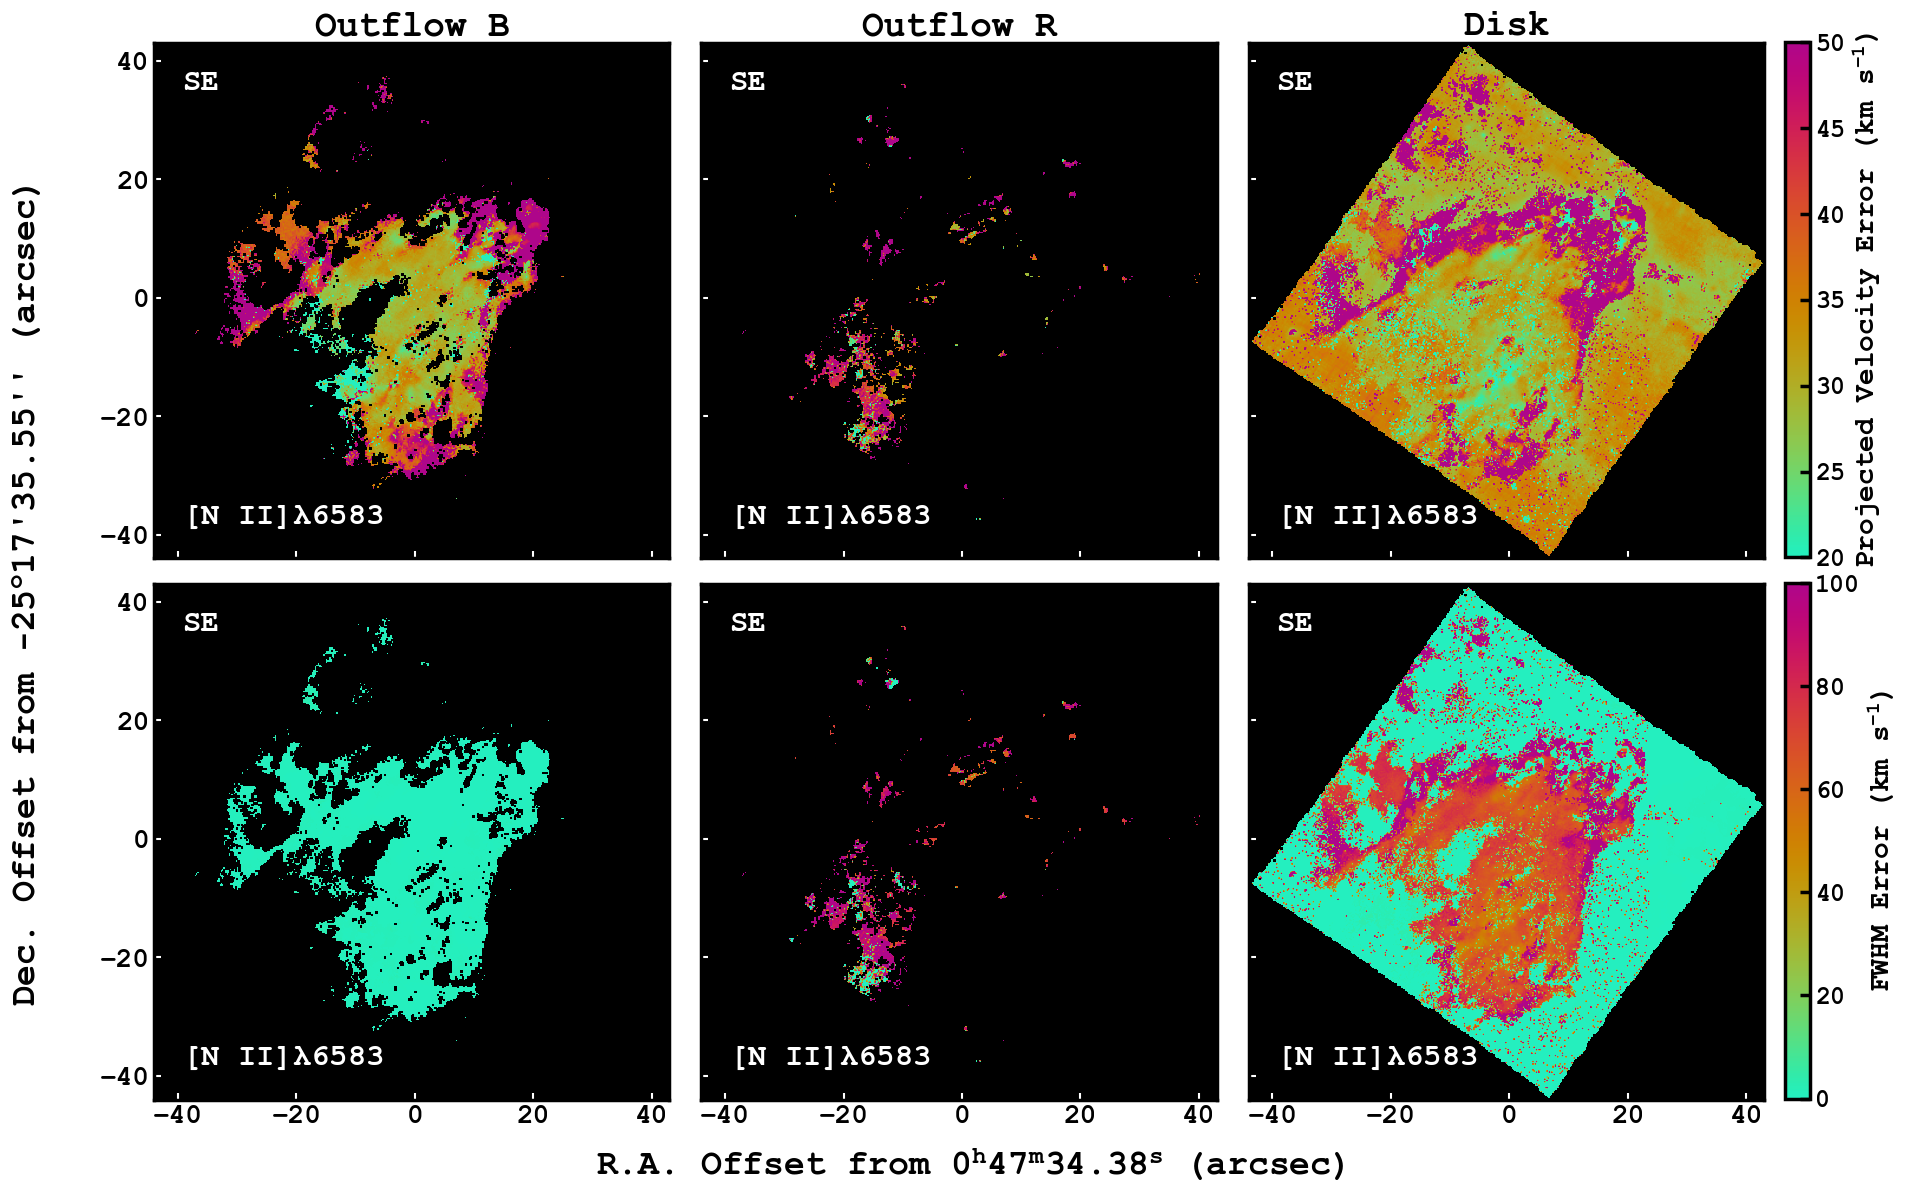

In [10]:
# plot the errors
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              outflow1_vel,
              outflow2_vel,
              disk_vel,
              vmin = 20,
              vmax = 50,
              titles = True,
              line_label = '[N II]$\lambda6583$',
              cbar_label = 'Projected Velocity Error (km s$^{-1}$)',
              cmap_name = 'cmr.tropical_r')

make_big_plot([ax4, ax5, ax6],
              outflow1_sig * 2.355,
              outflow2_sig * 2.355,
              disk_sig * 2.355,
              vmin = 0,
              vmax = 100,
              titles = False,
              line_label = '[N II]$\lambda6583$',
              cbar_label = 'FWHM Error (km s$^{-1}$)',
              cmap_name ='cmr.tropical_r')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,hspace=0.05)

plt.show()

Write everything to file to then be used for analysis in other notebooks.

In [14]:
# make the header
cube = SpectralCube.read('../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)  
hdr_vel = cube.header.copy()
hdr_vel['CUNIT3'] = 'km s-1'
hdr_vel['CTYPE3'] = ('VOPT-W2W', 'Optical velocity (linear)')

hdr_amp = cube.header.copy()
hdr_amp['CUNIT3'] = 'flux'
hdr_amp['CTYPE3'] = ('Flux')

In [15]:
hdul = fits.PrimaryHDU(data=disk_vel, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_vel_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_vel, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_vel_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_vel, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_vel_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_amp, header=hdr_amp)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amp_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_amp, header=hdr_amp)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amp_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_amp, header=hdr_amp)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amp_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_sig, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_sig_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_sig, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_sig_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_sig, header=hdr_vel)
hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_sig_outflow_red.fits',  overwrite=True)


# hdul = fits.PrimaryHDU(data=disk_amp_err, header=hdr)
# hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amperr_disk.fits',  overwrite=True)
# hdul = fits.PrimaryHDU(data=outflow1_amp_err, header=hdr)
# hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amperr_outflow_blue.fits',  overwrite=True)
# hdul = fits.PrimaryHDU(data=outflow2_amp_err, header=hdr)
# hdul.writeto('../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_niib_amperr_outflow_red.fits',  overwrite=True)
